<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%A8%88%E7%AE%97%E6%A8%A3%E6%9C%AC%E6%AC%8A%E9%87%8D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from math import log,sqrt
import warnings 
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
from math import e

#切比雪夫距離
def 切比雪夫距離(x1,x2):
  return np.max(np.abs(x1-x2))
#歐式距離
def 歐式距離(x1,x2):
  return sqrt(sum((x1-x2)**2))

def count_distance(x1,x2s):
  distance = []
  x1 = np.array(x1)
  x2s = np.array(x2s)
  for x2 in x2s:
    distance.append(歐式距離(x1,x2))
  return distance 

def tanh(x):
  return 2 / (1 + e**(-2*x)) -1

def get_sample_weight(distance):
  distance = np.array([ abs(d) for d in distance]) #距離絕對值
  sample_weight = 1/distance #距離愈遠重要度就低
  return [ tanh(x) for x in sample_weight]

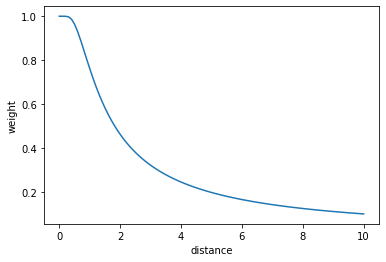

In [2]:
distance = np.linspace(0,10,100)
sample_weight = get_sample_weight(distance)
plt.plot(distance,sample_weight)
plt.xlabel('distance')
plt.ylabel('weight')
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/train_4521.csv',index_col=0)
test_250 = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
train = train.append(test_250[test_250.index%5 != 0])
test = test_250[test_250.index%5 == 0]
print(train.shape)
print(test.shape)

(4721, 27)
(50, 27)


In [5]:
train.head()

,T10,T50,T90,N+A,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


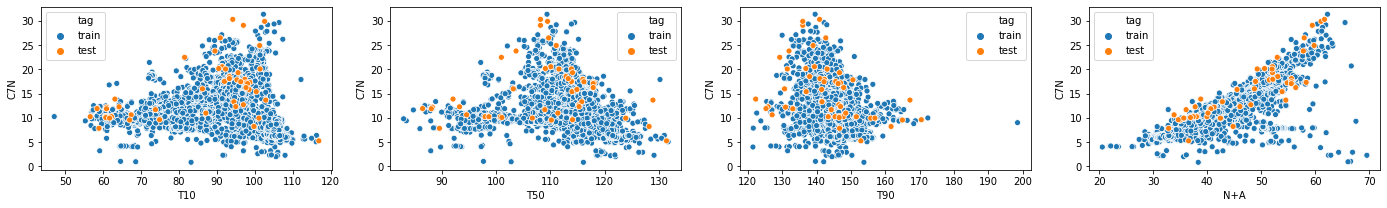

In [6]:
import seaborn as sns
features = train.iloc[:,:4].columns.tolist() 
y_columns = train.iloc[:,4:].columns.tolist()
y_name = 'C7N'
train['tag'] = 'train'
test['tag'] = 'test'
fig = plt.figure(figsize=(24,3))
for i,col in enumerate(features):
  plt.subplot(1,4,i+1)
  sns.scatterplot(x=col,y=y_name,data=train.append(test),hue='tag')
plt.show()

# scaler

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

# 特徵工程

In [0]:
train['F1'] = train['T90'] - train['T50']
test['F1'] = test['T90'] - test['T50']
train['F2'] = train['T50'] + train['N+A']
test['F2'] = test['T50'] + test['N+A']

In [0]:
features = ['T10','T50','T90','N+A','F1','F2']

In [10]:
train[features+[y_name]].corr()

,T10,T50,T90,N+A,F1,F2,C7N
T10,1.000000,0.895777,0.222374,-0.262436,-0.695075,0.565403,-0.258545
T50,0.895777,1.000000,0.530693,-0.372622,-0.484411,0.560079,-0.375491
T90,0.222374,0.530693,1.000000,-0.219104,0.484411,0.278165,-0.250653
N+A,-0.262436,-0.372622,-0.219104,1.000000,0.158459,0.560079,0.886806
F1,-0.695075,-0.484411,0.484411,0.158459,1.000000,-0.290987,0.128855
F2,0.565403,0.560079,0.278165,0.560079,-0.290987,1.000000,0.456467
C7N,-0.258545,-0.375491,-0.250653,0.886806,0.128855,0.456467,1.000000


# isomap

In [0]:
from sklearn.manifold import Isomap
iso_col = ['T10','T50','T90','N+A']
#create
iso = Isomap(n_components=2).fit(train[iso_col])
#train
temp = iso.transform(train[iso_col])
train['iso1'] = temp[:,0] 
train['iso2'] = temp[:,1]
#test
temp = iso.transform(test[iso_col])
test['iso1'] = temp[:,0] 
test['iso2'] = temp[:,1]

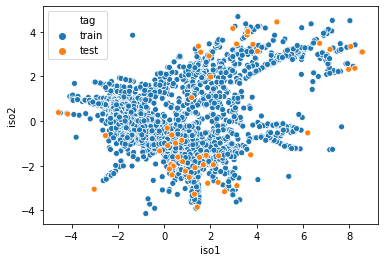

In [12]:
sns.scatterplot(x='iso1',y='iso2',data=train.append(test),hue='tag')

# 用one class svm計算權重

0.186181    3980
1.000000     741
Name: sample_weight, dtype: int64


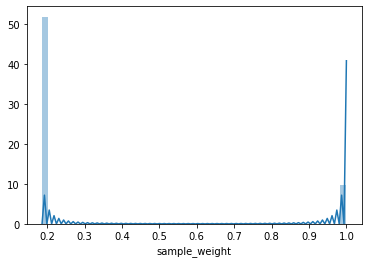

In [13]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(nu=0.01).fit(test[['iso1','iso2']+[y_name]])
train['sample_weight'] = ocsvm.predict(train[['iso1','iso2']+[y_name]])
p = train['sample_weight'].value_counts()[1]/train['sample_weight'].value_counts()[-1]
train['sample_weight'] = train['sample_weight'].replace(-1,p)
print(train['sample_weight'].value_counts())
sns.distplot(train['sample_weight'])

# 用距離計算權重

In [0]:
#from tqdm import tqdm_notebook as tqdm
#from sklearn.preprocessing import MinMaxScaler
#train['sample_weight'] = 0 
#for row in tqdm(test.index):
#  distance = count_distance(test.loc[row,['iso1','iso2']],train.loc[:,['iso1','iso2']])
#  weight = get_sample_weight(distance)
#  train['sample_weight'] += weight
#train['sample_weight'] = MinMaxScaler().fit_transform(train[['sample_weight']])
#train['sample_weight'] = train['sample_weight'].apply(round)
#sns.distplot(train['sample_weight'])

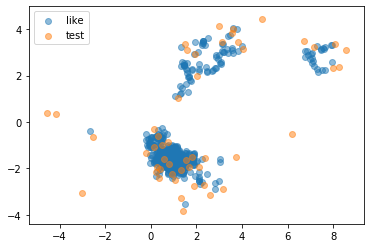

In [15]:
train['like'] = False
train.loc[train['sample_weight']>0.5,'like'] = True
like_point = train.loc[train.like==True]
plt.scatter(like_point['iso1'],like_point['iso2'],label='like',alpha=0.5)
plt.scatter(test['iso1'],test['iso2'],label='test',alpha=0.5)
plt.legend()
plt.show()

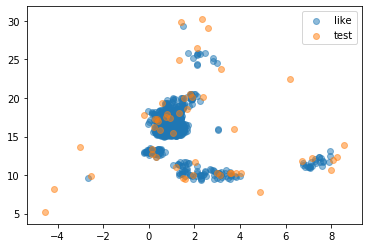

In [16]:
plt.scatter(like_point['iso1'],like_point[y_name],label='like',alpha=0.5)
plt.scatter(test['iso1'],test[y_name],label='test',alpha=0.5)
plt.legend()
plt.show()

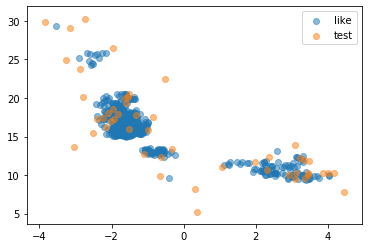

In [17]:
plt.scatter(like_point['iso2'],like_point[y_name],label='like',alpha=0.5)
plt.scatter(test['iso2'],test[y_name],label='test',alpha=0.5)
plt.legend()
plt.show()

# modeling

In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,max_error
import numpy as np
from math import sqrt
def metric(y_t,y_p,name):
  res = {'R2':np.max((r2_score(y_t,y_p),0)),
         'RMSE':sqrt(mean_squared_error(y_t,y_p)),
         'mean_absolute_error %':mean_absolute_error(y_t,y_p)/np.mean(y_t),
         'max_error':max_error(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

In [0]:
def pred_plot(df,by_col,name):
  df = df.sort_values(by = by_col)
  plt.plot(df[by_col],df['y_pred'],label= name+'_pred',color='red')
  plt.scatter(df[by_col],df[y_name],label= name+'_point')
  plt.xlabel(by_col)
  plt.ylabel(y_name)
  plt.legend()

In [20]:
by_col = abs(train[features+[y_name]].corr()[y_name].drop(y_name)).argmax()
by_col

'N+A'

# 正常

In [21]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm

X_train = train[features]
X_test = test[features]

res = pd.DataFrame()
for y_name in tqdm(y_columns):
  y_train = train[y_name]
  y_test = test[y_name]
  model = CatBoostRegressor(n_estimators=200,verbose=False)
  model.fit(X_train,y_train,
          eval_set = (X_train.sample(50,random_state=42),y_train.sample(50,random_state=42)))
  train['y_pred'] = model.predict(X_train)
  test['y_pred'] = model.predict(X_test)

  res = res.append(metric(test[y_name],test['y_pred'],y_name))
res.loc['AVG'] =res.mean()
res

,R2,RMSE,mean_absolute_error %,max_error
C5NP,0.959069,0.809214,0.138445,2.684524
C5IP,0.944575,0.701000,0.168284,2.137777
C5N,0.916006,0.091549,0.148176,0.274166
C6NP,0.865223,0.771123,0.147093,2.742397
C6IP,0.898520,0.878976,0.132045,3.019577
C6N,0.661206,1.051250,0.132508,3.171179
C6A,0.558733,0.634978,0.417387,2.505024
C7NP,0.368526,0.675254,0.104581,1.797389
C7IP,0.629553,0.951828,0.134038,3.255949
C7N,0.854698,2.246839,0.109971,6.848691


# 給樣本權重

In [22]:
X_train = train[features]
X_test = test[features]

res = pd.DataFrame()
for y_name in tqdm(y_columns):
  y_train = train[y_name]
  y_test = test[y_name]
  model = CatBoostRegressor(n_estimators=500,verbose=False)
  model.fit(X_train,y_train,
            sample_weight=train['sample_weight'].values,
            eval_set = (X_train.sample(50,random_state=42),y_train.sample(50,random_state=42)))
  train['y_pred'] = model.predict(X_train)
  test['y_pred'] = model.predict(X_test)

  res = res.append(metric(test[y_name],test['y_pred'],y_name))
res.loc['AVG'] =res.mean()
res

,R2,RMSE,mean_absolute_error %,max_error
C5NP,0.973080,0.656251,0.115660,1.665173
C5IP,0.963406,0.569599,0.135938,1.661579
C5N,0.938076,0.078607,0.125697,0.285729
C6NP,0.901794,0.658241,0.115591,2.315890
C6IP,0.904634,0.852088,0.121937,2.947488
C6N,0.721411,0.953280,0.109800,3.170271
C6A,0.473655,0.693495,0.384535,3.317180
C7NP,0.534796,0.579577,0.084925,1.334896
C7IP,0.650147,0.924993,0.113529,3.630259
C7N,0.899066,1.872639,0.088961,6.033705
